In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import sak
import sak.signal.wavelet
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from sak.signal import StandardHeader

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic


def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig


In [151]:
dataset = {}
Pon = {}
Ppeak = {}
Poff = {}
QRSon = {}
QRSpeak = {}
QRSoff = {}
Ton = {}
Tpeak = {}
Toff = {}
group = {}

for i in range(200):
    (signal, header) = wfdb.rdsamp(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1))
    sortOrder = np.where(np.array([x.upper() for x in header['sig_name']])[:,None] == StandardHeader)[1]
    signal = signal[:,sortOrder]
    if header['fs'] != 500:
        print(header['fs'])
    signal = sp.signal.decimate(signal,2,axis=0)
    
    for j in range(len(StandardHeader)):
        lead = StandardHeader[j]
        name = str(i+1)+"_"+lead
        ann = wfdb.rdann(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1),'atr_{}'.format(lead.lower()))
        dataset[name] = signal[:,j]
        
        locP = np.where(np.array(ann.symbol) == 'p')[0]
        if len(locP) != 0:
            if locP[0]-1 < 0:
                locP = locP[1:]
            if locP[-1]+1 == len(ann.sample):
                locP = locP[:-1]
        Pon[name] = ann.sample[locP-1]//2
        Ppeak[name] = ann.sample[locP]//2
        Poff[name] = ann.sample[locP+1]//2

        locQRS = np.where(np.array(ann.symbol) == 'N')[0]
        if len(locQRS) != 0:
            if locQRS[0]-1 < 0:
                locQRS = locQRS[1:]
            if locQRS[-1]+1 == len(ann.sample):
                locQRS = locQRS[:-1]
        QRSon[name] = ann.sample[locQRS-1]//2
        QRSpeak[name] = ann.sample[locQRS]//2
        QRSoff[name] = ann.sample[locQRS+1]//2

        locT = np.where(np.array(ann.symbol) == 't')[0]
        if len(locT) != 0:
            if locT[0]-1 < 0:
                locT = locT[1:]
            if locT[-1]+1 == len(ann.sample):
                locT = locT[:-1]
        Ton[name] = ann.sample[locT-1]//2
        Tpeak[name] = ann.sample[locT]//2
        Toff[name] = ann.sample[locT+1]//2
        
        # Store group
        group[name] = str(i+1)

dataset = pd.DataFrame(dataset)

In [183]:
Psignal = {}
PQsignal = {}
QRSsignal = {}
STsignal = {}
Tsignal = {}
TPsignal = {}

Pwavelet = {}
PQwavelet = {}
QRSwavelet = {}
STwavelet = {}
Twavelet = {}
TPwavelet = {}

Pgroup = {}
PQgroup = {}
QRSgroup = {}
STgroup = {}
Tgroup = {}
TPgroup = {}

for k in dataset:
    for i in range(len(Pon[k])):
        Psignal[k + '_' + str(i)] = dataset[k][Pon[k][i]:Poff[k][i]].values
        Pwavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(Psignal[k + '_' + str(i)], 250.)
        Pgroup[k + '_' + str(i)] = k
        
        # PQ wave
        if QRSon[k].size != 0:
            j = np.argmax(Poff[k][i] < QRSon[k])
            if Poff[k][i] < QRSon[k][j]: # Avoid issues with argmax
                if not np.any([
                    np.any((Pon[k] > Poff[k][i]) & (Pon[k] < QRSon[k][j])),
                    np.any((Poff[k] > Poff[k][i]) & (Poff[k] < QRSon[k][j])),
                    np.any((QRSon[k] > Poff[k][i]) & (QRSon[k] < QRSon[k][j])),
                    np.any((QRSoff[k] > Poff[k][i]) & (QRSoff[k] < QRSon[k][j])),
                    np.any((Ton[k] > Poff[k][i]) & (Ton[k] < QRSon[k][j])),
                    np.any((Toff[k] > Poff[k][i]) & (Toff[k] < QRSon[k][j])),
                ]):
                    PQsignal[k + '_' + str(i)] = dataset[k][Poff[k][i]:QRSon[k][j]].values
                    PQwavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(PQsignal[k + '_' + str(i)], 250.)
                    PQgroup[k + '_' + str(i)] = k

        # TP wave
        if Toff[k].size != 0:
            j = np.argmin(Toff[k] < Pon[k][i])-1
            if j >= 0: # Avoid issues with argmin
                if not np.any([
                    np.any((Pon[k] < Pon[k][i]) & (Pon[k] > Toff[k][j])),
                    np.any((Poff[k] < Poff[k][i]) & (Poff[k] > Toff[k][j])),
                    np.any((QRSon[k] < Poff[k][i]) & (QRSon[k] > Toff[k][j])),
                    np.any((QRSoff[k] < Poff[k][i]) & (QRSoff[k] > Toff[k][j])),
                    np.any((Ton[k] < Poff[k][i]) & (Ton[k] > Toff[k][j])),
                    np.any((Toff[k] < Poff[k][i]) & (Toff[k] > Toff[k][j])),
                ]):
                    TPsignal[k + '_' + str(i)] = dataset[k][Toff[k][j]:Pon[k][i]].values
                    TPwavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(TPsignal[k + '_' + str(i)], 250.)
                    TPgroup[k + '_' + str(i)] = k

    for i in range(len(QRSon[k])):
        QRSsignal[k + '_' + str(i)] = dataset[k][QRSon[k][i]:QRSoff[k][i]].values
        QRSwavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(QRSsignal[k + '_' + str(i)], 250.)
        QRSgroup[k + '_' + str(i)] = k

        # ST wave
        if Ton[k].size != 0:
            j = np.argmax(QRSoff[k][i] < Ton[k])
            if QRSoff[k][i] < Ton[k][j]: # Avoid issues with argmax
                if not np.any([
                    np.any((Pon[k] > QRSoff[k][i]) & (Pon[k] < Ton[k][j])),
                    np.any((Poff[k] > QRSoff[k][i]) & (Poff[k] < Ton[k][j])),
                    np.any((QRSon[k] > QRSoff[k][i]) & (QRSon[k] < Ton[k][j])),
                    np.any((QRSoff[k] > QRSoff[k][i]) & (QRSoff[k] < Ton[k][j])),
                    np.any((Ton[k] > QRSoff[k][i]) & (Ton[k] < Ton[k][j])),
                    np.any((Toff[k] > QRSoff[k][i]) & (Toff[k] < Ton[k][j])),
                ]):
                    STsignal[k + '_' + str(i)] = dataset[k][QRSoff[k][i]:Ton[k][j]].values
                    STwavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(STsignal[k + '_' + str(i)], 250.)
                    STgroup[k + '_' + str(i)] = k

    for i in range(len(Ton[k])):
        Tsignal[k + '_' + str(i)] = dataset[k][Ton[k][i]:Toff[k][i]].values
        Twavelet[k + '_' + str(i)] = sak.signal.wavelet.transform(Tsignal[k + '_' + str(i)], 250.)
        Tgroup[k + '_' + str(i)] = k
    

In [153]:
# # Filter out
# for k in list(Psignal.keys()):
#     if ((Psignal[k].size < 5) | (Psignal[k].size > 100)):
#         Psignal.pop(k)
#         Pwavelet.pop(k)
#         Pgroup.pop(k)
# for k in list(PQsignal.keys()):
#     if ((PQsignal[k].size < 5) | (PQsignal[k].size > 100)):
#         PQsignal.pop(k)
#         PQwavelet.pop(k)
#         PQgroup.pop(k)
# for k in list(QRSsignal.keys()):
#     if ((QRSsignal[k].size < 5) | (QRSsignal[k].size > 100)):
#         QRSsignal.pop(k)
#         QRSwavelet.pop(k)
#         QRSgroup.pop(k)
# for k in list(STsignal.keys()):
#     if ((STsignal[k].size < 5) | (STsignal[k].size > 100)):
#         STsignal.pop(k)
#         STwavelet.pop(k)
#         STgroup.pop(k)
# for k in list(Tsignal.keys()):
#     if ((Tsignal[k].size < 5) | (Tsignal[k].size > 100)):
#         Tsignal.pop(k)
#         Twavelet.pop(k)
#         Tgroup.pop(k)
# for k in list(TPsignal.keys()):
#     if ((TPsignal[k].size < 5) | (TPsignal[k].size > 100)):
#         TPsignal.pop(k)
#         TPwavelet.pop(k)
#         TPgroup.pop(k)

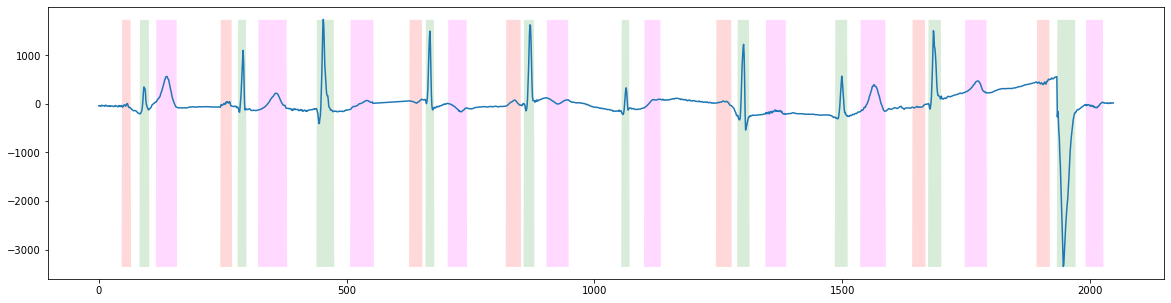

In [191]:
N = 2048

beats = []
ids = []

# Include first beat
ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
beats.append(sak.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
size = beats[0].size
masks = np.zeros((size,))
onset = np.random.randint(0,size)
while size-onset < N:
    # P wave (sometimes)
    if np.random.rand(1) < 0.5:
        # p = sak.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
        ids.append(('Psignal',np.random.randint(0,len(Psignal))))
        p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
        # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
        beats.append(p)
        masks = np.concatenate((masks,1*np.ones((p.size,))))

    # PQ segment
    # pq = sak.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
    ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
    pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
    # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
    beats.append(pq)
    masks = np.concatenate((masks,np.zeros((pq.size,))))

    # QRS wave
    # qrs = sak.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
    ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
    qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
    # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
    beats.append(qrs)
    masks = np.concatenate((masks,2*np.ones((qrs.size,))))

    # ST segment
    # st = sak.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
    ids.append(('STsignal',np.random.randint(0,len(STsignal))))
    st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
    # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
    beats.append(st)
    masks = np.concatenate((masks,np.zeros((st.size,))))

    # T wave
    # t = sak.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
    ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
    t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
    # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
    beats.append(t)
    masks = np.concatenate((masks,3*np.ones((t.size,))))

    # TP segment
    # tp = sak.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
    ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
    tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
    # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
    beats.append(tp)
    masks = np.concatenate((masks,np.zeros((tp.size,))))

    size = sum([beats[i].size for i in range(len(beats))])

w = 51
sig = np.concatenate(beats)[onset:onset+2048]
sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

masks = masks[onset:onset+2048]
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = masks == 1
masks_all[:,1] = masks == 2
masks_all[:,2] = masks == 3
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

# New method

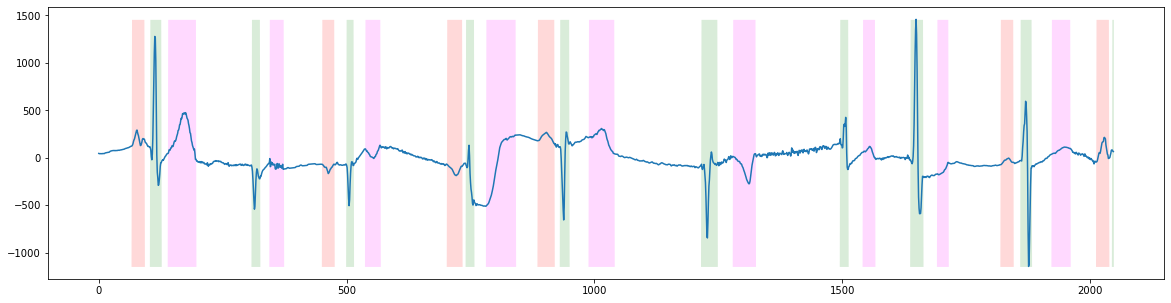

In [192]:
N = 2048

beats = []
ids = []

# Include first beat
ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
beats.append(sak.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
size = beats[0].size
masks = np.zeros((size,))
onset = np.random.randint(0,size)
while size-onset < N:
    # P wave (sometimes)
    if np.random.rand(1) < 0.5:
        # p = sak.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
        ids.append(('Psignal',np.random.randint(0,len(Psignal))))
        p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
        # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
        beats.append(p)
        masks = np.concatenate((masks,1*np.ones((p.size,))))

    # PQ segment
    # pq = sak.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
    ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
    pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
    # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
    beats.append(pq)
    masks = np.concatenate((masks,np.zeros((pq.size,))))

    # QRS wave
    # qrs = sak.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
    ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
    qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
    # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
    beats.append(qrs)
    masks = np.concatenate((masks,2*np.ones((qrs.size,))))

    # ST segment
    # st = sak.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
    ids.append(('STsignal',np.random.randint(0,len(STsignal))))
    st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
    # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
    beats.append(st)
    masks = np.concatenate((masks,np.zeros((st.size,))))

    # T wave
    # t = sak.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
    ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
    t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
    # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
    beats.append(t)
    masks = np.concatenate((masks,3*np.ones((t.size,))))

    # TP segment
    # tp = sak.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
    ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
    tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
    # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
    beats.append(tp)
    masks = np.concatenate((masks,np.zeros((tp.size,))))

    size = sum([beats[i].size for i in range(len(beats))])

w = 51
sig = np.concatenate(beats)[onset:onset+2048]
sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

masks = masks[onset:onset+2048]
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = masks == 1
masks_all[:,1] = masks == 2
masks_all[:,2] = masks == 3
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

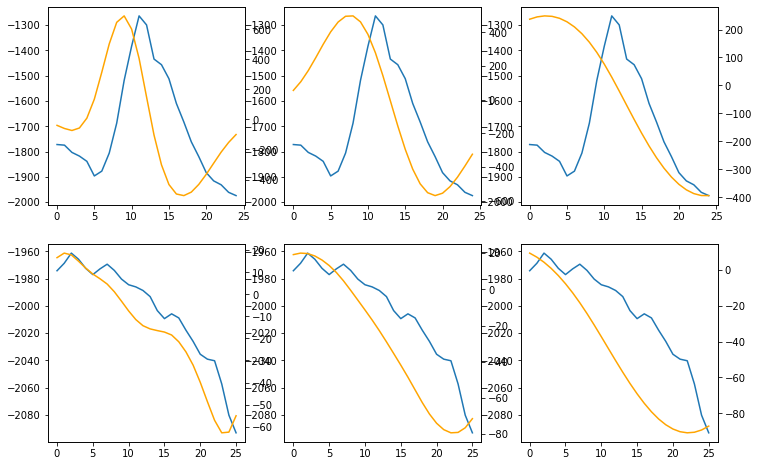

In [333]:
single_beat = []

# TP segment
# tp = sak.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
ids.append(np.random.randint(0,len(TPsignal)))
types.append('TPsignal')
tp = trailonset(TPsignal[list(TPsignal)[ids[-1]]],beats[-1][-1])
tpwvlt = TPwavelet[list(TPwavelet)[ids[-1]]]# tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
beats.append(tp)
masks = np.concatenate((masks,np.zeros((tp.size,))))

# P wave (sometimes)
if np.random.rand(1) < 0.5:
    # p = sak.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
    ids.append(np.random.randint(0,len(Psignal)))
    types.append('Psignal')
    p = trailonset(Psignal[list(Psignal)[ids[-1]]],beats[-1][-1])
    pwvlt = Pwavelet[list(Pwavelet)[ids[-1]]]    # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
    beats.append(p)
    masks = np.concatenate((masks,1*np.ones((p.size,))))

# PQ segment
# pq = sak.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
ids.append(np.random.randint(0,len(PQsignal)))
types.append('PQsignal')
pq = trailonset(PQsignal[list(PQsignal)[ids[-1]]],beats[-1][-1])
pqwvlt = PQwavelet[list(PQwavelet)[ids[-1]]]# pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
beats.append(pq)
masks = np.concatenate((masks,np.zeros((pq.size,))))

# QRS wave
# qrs = sak.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
ids.append(np.random.randint(0,len(QRSsignal)))
types.append('QRSsignal')
qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1]]],beats[-1][-1])
qrswvlt = QRSwavelet[list(QRSwavelet)[ids[-1]]]# qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
beats.append(qrs)
masks = np.concatenate((masks,2*np.ones((qrs.size,))))

# ST segment
# st = sak.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
ids.append(np.random.randint(0,len(STsignal)))
types.append('STsignal')
st = trailonset(STsignal[list(STsignal)[ids[-1]]],beats[-1][-1])
stwvlt = STwavelet[list(STwavelet)[ids[-1]]]# st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
beats.append(st)
masks = np.concatenate((masks,np.zeros((st.size,))))

# T wave
# t = sak.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
ids.append(np.random.randint(0,len(Tsignal)))
types.append('Tsignal')
t = trailonset(Tsignal[list(Tsignal)[ids[-1]]],beats[-1][-1])
twvlt = Twavelet[list(Twavelet)[ids[-1]]]# t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
beats.append(t)
masks = np.concatenate((masks,3*np.ones((t.size,))))

size = sum([beats[i].size for i in range(len(beats))])

f,ax=plt.subplots(nrows=2,ncols=3,figsize=(12,8))
ax[0,0].plot(qrs)
ax[0,0] = ax[0,0].twinx()
ax[0,0].plot(qrswvlt[:,0,2], color='orange')
ax[0,1].plot(qrs)
ax[0,1] = ax[0,1].twinx()
ax[0,1].plot(qrswvlt[:,0,3], color='orange')
ax[0,2].plot(qrs)
ax[0,2] = ax[0,2].twinx()
ax[0,2].plot(qrswvlt[:,0,4], color='orange')
ax[1,0].plot(st)
ax[1,0] = ax[1,0].twinx()
ax[1,0].plot(stwvlt[:,0,2], color='orange')
ax[1,1].plot(st)
ax[1,1] = ax[1,1].twinx()
ax[1,1].plot(stwvlt[:,0,3], color='orange')
ax[1,2].plot(st)
ax[1,2] = ax[1,2].twinx()
ax[1,2].plot(stwvlt[:,0,4], color='orange')
plt.show()


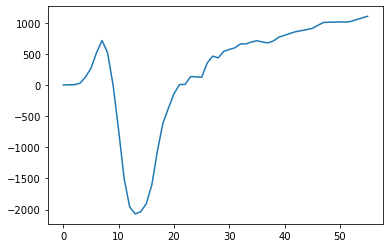

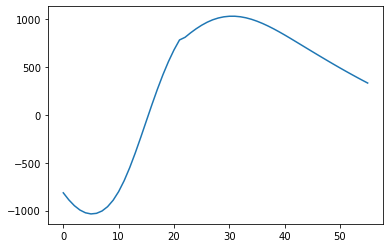

In [332]:
qrsmierdercompatible = trailonset(QRSsignal[list(QRSsignal)[10328]],0)
stmierder = trailonset(8.2*STsignal[list(STsignal)[5375]],qrsmierdercompatible[-1])
wvltqrs = sak.signal.wavelet.transform(qrsmierdercompatible,250.)
wvltst = sak.signal.wavelet.transform(stmierder,250.)
plt.figure()
plt.plot(np.concatenate((qrsmierdercompatible,stmierder)))
plt.figure()
plt.plot(np.concatenate((wvltqrs[:,0,4],wvltst[:,0,4])))
plt.show()